# Installing the Dependencies

<a target="_blank" href="https://colab.research.google.com/github/yandexdataschool/nlp_course/blob/quantization/week10_quantization/benchmark.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%%capture
%pip install transformers==4.35.0
%pip install accelerate==0.24.1
%pip install Ninja==1.11.1.1

### Imports

In [ ]:
import time
from typing import Callable
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn

from transformers.models.llama.modeling_llama import LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig
import accelerate

# Quantization Reduces Memory Footprint

In PyTorch, basic tensors are stored as continious arrays of densely packed values. That is, for a basic tensor, the amount of memory a tensor requires can be easily infered from it's size and data type.

The function below demonstrates that the amount of allocated GPU memory is consistent with those parameters.

In [ ]:
def measure_bits_per_coordinate(size: int, dtype: torch.dtype) -> float:
    """Measure tensor memory footprint by measuring allocated memory, creating a tensor and measuring allocated memory again.
    Args:
        size (int): size of the tensor to be allocated
        dtype (torch.dtype): data type of the tensor to be allocated

    Returns:
        float: tensor memory footprint divided by it's size
    """
    torch.cuda.empty_cache()
    baseline = torch.cuda.memory_allocated() * 8
    tensor = torch.empty((size,), dtype=dtype, device="cuda")
    allocated = torch.cuda.memory_allocated() * 8
    return (allocated - baseline) / size

print(f"float16: {measure_bits_per_coordinate(4096, torch.float16):.0f}")
print(f"int8: {measure_bits_per_coordinate(4096, torch.int8):.0f}")

float16: 16
int8: 8


In this notebook, we'll be working with `LLaMA-7b` model, that contains 7 billion parameters. In `float16`, that would amount to about *14 Gb* of model weigts. The colab *GPU* can barely fit it, and it's not nearly enough to run it on long sequences.

As we have seen above, storing the model weights in small integer data types can greatly decrease it's memory footprint. We'll refer to this as quantization. For the sake of simplicity, we'll focus on quantization of `nn.Linear` layers, that make up the majority of the model weights.

The function below calculates the expected `LLaMA-7b` memory footprint if all the `nn.Linear` layers were converted to a lower-bits representation.

In [ ]:
LLAMA_REPO = "yahma/llama-7b-hf"


def measure_model_footrpint(model: nn.Module, bits: int) -> float:
    """
    Args:
        model (nn.Module): model to calculate the memory footprint of
        bits (int): bits per coordinate for linear layers

    Returns:
        float: memory footprint in bits
    """
    memory_footpring_bits = 0
    if isinstance(model, nn.Linear):
        memory_footpring_bits = bits * model.weight.data.numel()
    elif len(list(model.children())) == 0:
        for p in model.parameters():
            memory_footpring_bits += p.data.numel() * 16

    for name, child in model.named_children():
        memory_footpring_bits += measure_model_footrpint(child, bits)

    return memory_footpring_bits


with accelerate.init_empty_weights():
    model = LlamaForCausalLM(LlamaConfig.from_pretrained(LLAMA_REPO))

llama_size_fp16_gb = measure_model_footrpint(model, 16) * 2 ** (-33)
llama_size_int8_gb = measure_model_footrpint(model, 8) * 2 ** (-33)
llama_size_int4_gb = measure_model_footrpint(model, 4) * 2 ** (-33)

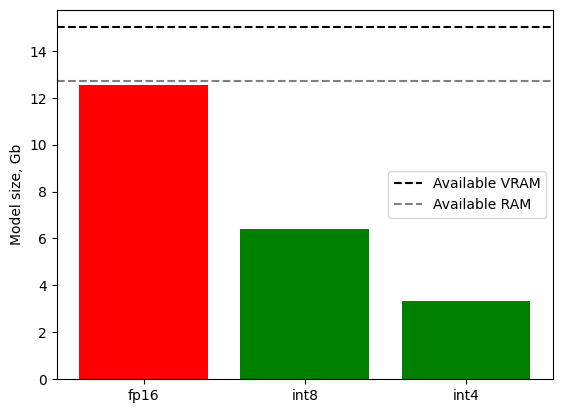

In [ ]:
dtypes = ['fp16', 'int8', 'int4']
sizes = [llama_size_fp16_gb, llama_size_int8_gb, llama_size_int4_gb]
bar_colors = ['red', 'green', 'green']

plt.bar(dtypes, sizes, color=bar_colors)
plt.ylabel("Model size, Gb")
plt.axhline(15.0, linestyle="--", color="black", label="Available VRAM")
plt.axhline(12.7, linestyle="--", color="gray", label="Available RAM")
plt.legend()
plt.show()

As we can see, we can easily fit the quantized model into both RAM and VRAM.

# Quantized Tensors are Faster to Multiply

In [ ]:
@torch.no_grad()
def benchmark_multiplication(
    batch_size: int,
    input_size: int,
    output_size: int,
    n_repeats: int,
    dtype: torch.dtype,
    matmul_fn: Callable[[Tensor, Tensor], Tensor],
    device:torch.device="cuda"
) -> float:
    """
    Args:
        batch_size (int): first tensor outer shape
        input_size (int): first tensor inner shape = second tensor inner shape
        output_size (int): second tensor outer shape
        n_repeats (int): number of multiplications benchmarked
        dtype (torch.dtype): data type of the tensors
        matmul_fn (Callable[[Tensor, Tensor], Tensor]): a function performing the matrix multiplication
        device (torch.device, optional): device to perform multiplication on. Defaults to "cuda".

    Returns:
        float: total time in seconds
    """
    weight = torch.empty((output_size, input_size), dtype=dtype, device=device) # notice that output_size is first
    input = torch.empty((batch_size, input_size), dtype=dtype, device=device)

    # Preheat
    # YOUR CODE HERE>>>>>>>>>
    for i in range(n_repeats):
        _ = matmul_fn(input, weight)
    # <<<<<<<<<<<<<<<<<<<<<<<
    torch.cuda.synchronize()

    start = time.time()
    # YOUR CODE HERE>>>>>>>>>
    for i in range(n_repeats):
        _ = matmul_fn(input, weight)
    # <<<<<<<<<<<<<<<<<<<<<<<
    torch.cuda.synchronize()
    end = time.time()

    return end - start


### Int-4 multiplication

Torch doesn't navtively support Int4 multiplication. We'll have to write our own GPU multiplication kernels, using CUDA toolkit and [cutlass](https://github.com/NVIDIA/cutlass) - a dedicated linear algebra package for CUDA.

**Install CUDA 12.3 and cutlass**

In [ ]:
%%capture
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/12.3.0/local_installers/cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu2204-12-3-local/cuda-*-keyring.gpg /usr/share/keyrings/
!sudo apt-get update
!sudo apt-get -y install cuda-toolkit-12-3
!pip install --upgrade pip

!git clone https://github.com/NVIDIA/cutlass.git
!export CUDACXX=/usr/local/cuda/bin/nvcc
!cd cutlass && mkdir build && cd build && cmake .. -DCUTLASS_NVCC_ARCHS=75

**Loading custom CUDA kernels**

Along with this jupyter notebook, two `CUDA` files are provided, implementing efficient matrix multiplication for `int4` and `int8`.

In [2]:
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_quantization/kernel.cpp --no-check-certificate
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_quantization/kernel.cu --no-check-certificate

File ‘kernel.cpp’ already there; not retrieving.

File ‘kernel.cu’ already there; not retrieving.



In [ ]:
from torch.utils.cpp_extension import load

custom_kernel = load(name='custom_kernel', sources=['kernel.cpp', 'kernel.cu'], extra_include_paths=[r"cutlass/include"])

Usage: `output = custom_kernel.int8_matmul(X, Y)` and `output = custom_kernel.int4_matmul(X, Y)` compute $XY^T$ (same as `torch.nn.functional.linear`).

Notice that `int8_matmul` takes the normal `torch.int8` tensors, but int4_matmul expects `int4` values densely packed into `torch.uint8` tensors. Without goint into further detail, an `int4` matrix of size `A x B` would be represented by a `torch.uint8` tensor of shape `A x B//2`. Remember that when benchmarking the operations.

### Benchmarking matmul

In [ ]:
n_repeats = 256
batch_size = 1024
input_size = output_size = 4096

torch.cuda.empty_cache()
# YOUR CODE HERE>>>>>>>>>
fp16_ms = benchmark_multiplication(batch_size, input_size, output_size, n_repeats, torch.float16, nn.functional.linear) / n_repeats* 1000
int8_ms = benchmark_multiplication(batch_size, input_size, output_size, n_repeats, torch.int8, custom_kernel.int8_matmul) / n_repeats * 1000
int4_ms = benchmark_multiplication(batch_size, input_size // 2, output_size, n_repeats, torch.uint8, custom_kernel.int4_matmul) / n_repeats * 1000
# <<<<<<<<<<<<<<<<<<<<<<<

print(f"fp16: {fp16_ms:.2f} ms")
print(f"int8: {int8_ms:.2f} ms")
print(f"int4: {int4_ms:.2f} ms")

fp16: 2.24 ms
int8: 1.30 ms
int4: 0.70 ms


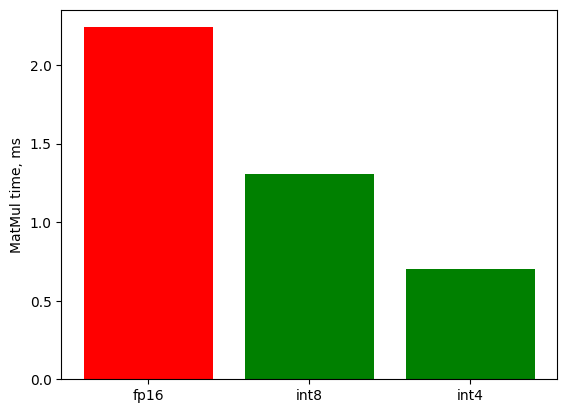

In [ ]:
dtypes = ['fp16', 'int8', 'int4']
times = [fp16_ms, int8_ms, int4_ms]
bar_colors = ['red', 'green', 'green']

plt.bar(dtypes, times, color=bar_colors)
plt.ylabel("MatMul time, ms")
plt.show()